In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rania121","key":"214a81c41cafd2a04cf2b029606405a5"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content
!unzip -q /content/skin-cancer-mnist-ham10000.zip -d /content/ham10000_images

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:22<00:00, 168MB/s]
100% 5.20G/5.20G [01:24<00:00, 65.9MB/s]


In [4]:
!kaggle datasets download -d tschandl/ham10000-lesion-segmentations
!unzip ham10000-lesion-segmentations.zip -d ham10000_masks


Streaming output truncated to the last 5000 lines.
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029321_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029322_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029323_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029324_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029325_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029326_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029327_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029328_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_tschandl/ISIC_0029329_segmentation.png  
  inflating: ham10000_masks/HAM10000_segmentations_lesion_

In [5]:
import glob
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import albumentations as A
from albumentations.core.composition import OneOf
from albumentations.pytorch import ToTensorV2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dense, UpSampling2D, Conv2DTranspose, Flatten, Reshape, concatenate
from tensorflow.keras.models import Model

In [6]:
img_size = (128, 128)

part1_paths = glob.glob("ham10000_images/HAM10000_images_part_1/*.jpg")
part2_paths = glob.glob("ham10000_images/HAM10000_images_part_2/*.jpg")
mask_paths  = glob.glob("ham10000_masks/HAM10000_segmentations_lesion_tschandl/*.png")

all_image_paths = part1_paths + part2_paths

print(f"Total images: {len(all_image_paths)}")
print(f"Total masks: {len(mask_paths)}")

# Checking matching names
image_names = set([os.path.basename(p).replace(".jpg", "") for p in all_image_paths])
mask_names  = set([os.path.basename(p).replace(".png", "") for p in mask_paths])

common_names = image_names.intersection(mask_names)
print(f"Images with matching masks: {len(common_names)}")


Total images: 10015
Total masks: 10015
Images with matching masks: 0


In [7]:
images_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in all_image_paths}

masks_dict = {}
for p in mask_paths:
    base = os.path.splitext(os.path.basename(p))[0]
    base = base.replace("_segmentation", "").replace("_lesion", "")
    masks_dict[base] = p

# Find common keys
common_keys = images_dict.keys() & masks_dict.keys()

print(f"Total images: {len(all_image_paths)}")
print(f"Total masks: {len(mask_paths)}")
print(f"Images with matching masks: {len(common_keys)}")

Total images: 10015
Total masks: 10015
Images with matching masks: 10015


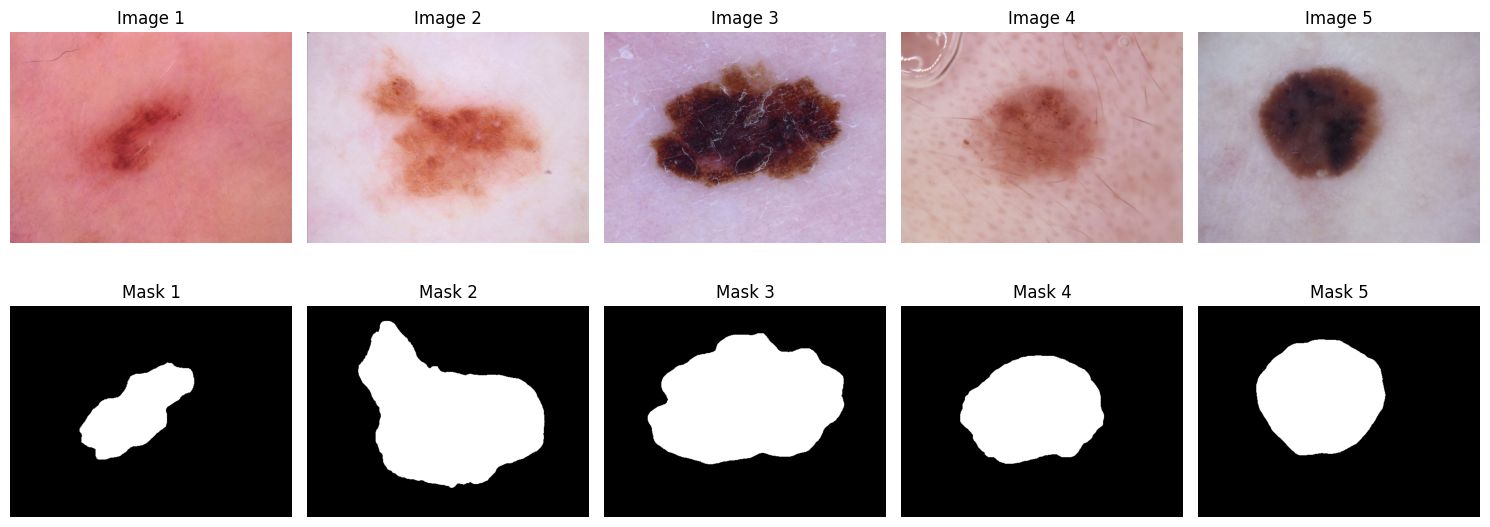

In [8]:
num_samples = 5
sample_keys = list(common_keys)[:num_samples]

fig, axes = plt.subplots(2, num_samples, figsize=(num_samples * 3, 6))

for i, key in enumerate(sample_keys):
    img = cv2.imread(images_dict[key])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_dict[key], cv2.IMREAD_GRAYSCALE)

    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Image {i+1}", fontsize=12)
    axes[0, i].axis("off")

    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Mask {i+1}", fontsize=12)
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()


In [9]:
# First split
train_keys, temp_keys = train_test_split(
    list(common_keys),
    test_size=0.3,
    random_state=42
)

# Second split
val_keys, test_keys = train_test_split(
    temp_keys,
    test_size=0.5,
    random_state=42
)

print(f"Train set: {len(train_keys)} images")
print(f"Validation set: {len(val_keys)} images")
print(f"Test set: {len(test_keys)} images")


Train set: 7010 images
Validation set: 1502 images
Test set: 1503 images


In [10]:
# Augmentation
transform_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5)
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


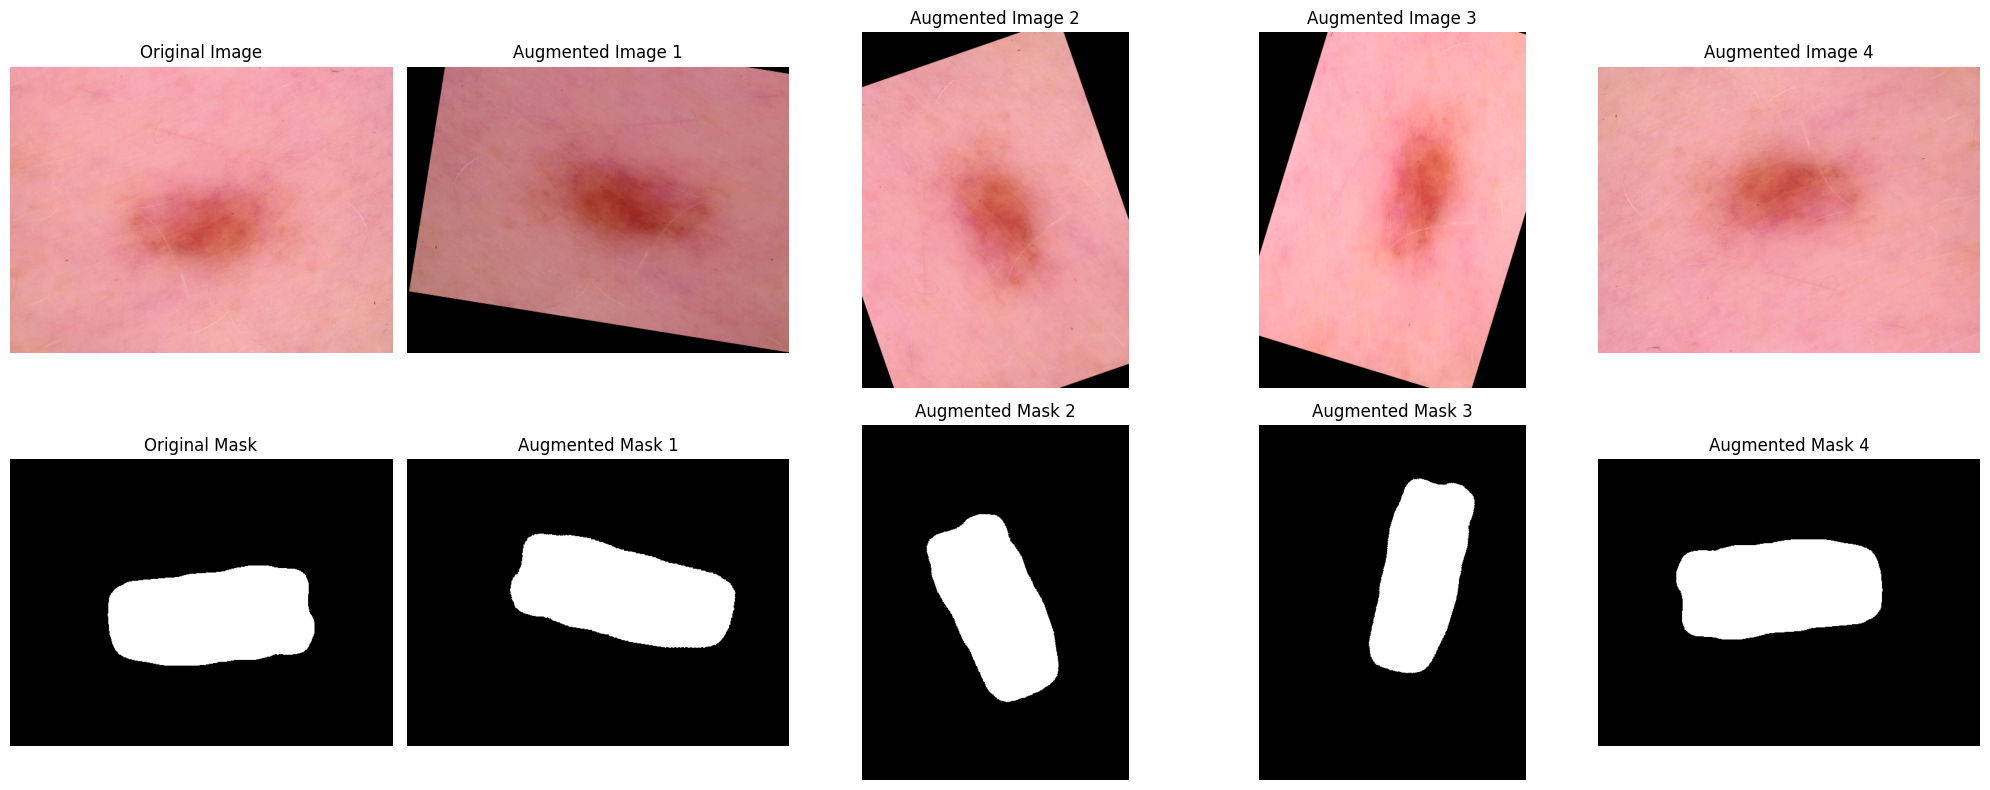

In [11]:
def show_augmentations(key, n_augmentations=4):
    img = cv2.imread(images_dict[key])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(masks_dict[key], cv2.IMREAD_GRAYSCALE)

    fig, axes = plt.subplots(2, n_augmentations + 1, figsize=(4 * (n_augmentations + 1), 8))

    axes[0, 0].imshow(img)
    axes[0, 0].set_title("Original Image")
    axes[0, 0].axis('off')

    axes[1, 0].imshow(mask, cmap='gray')
    axes[1, 0].set_title("Original Mask")
    axes[1, 0].axis('off')

    for i in range(n_augmentations):
        augmented = transform_train(image=img, mask=mask)
        img_aug = augmented['image']
        mask_aug = augmented['mask']

        axes[0, i+1].imshow(img_aug)
        axes[0, i+1].set_title(f"Augmented Image {i+1}")
        axes[0, i+1].axis('off')

        axes[1, i+1].imshow(mask_aug, cmap='gray')
        axes[1, i+1].set_title(f"Augmented Mask {i+1}")
        axes[1, i+1].axis('off')

    plt.tight_layout()
    plt.show()

show_augmentations(train_keys[0], n_augmentations=4)


In [12]:
IMG_SIZE = 128

def load_data(keys, augment=False):
    X, Y = [], []
    for key in keys:
        img = cv2.imread(images_dict[key])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(masks_dict[key], cv2.IMREAD_GRAYSCALE)

        if augment:
            augmented = transform_train(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

# Resize + normalize
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST) / 255.0
        mask = np.expand_dims(mask, axis=-1)


        X.append(img)
        Y.append(mask)

    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

# Load datasets
X_train, Y_train = load_data(train_keys, augment=True)
X_val, Y_val     = load_data(val_keys, augment=False)
X_test, Y_test   = load_data(test_keys, augment=False)

print("Train:", X_train.shape, Y_train.shape)
print("Validation:", X_val.shape, Y_val.shape)
print("Test:", X_test.shape, Y_test.shape)

Train: (7010, 128, 128, 3) (7010, 128, 128, 1)
Validation: (1502, 128, 128, 3) (1502, 128, 128, 1)
Test: (1503, 128, 128, 3) (1503, 128, 128, 1)


In [13]:
# Dice loss
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1)

# IoU loss
def iou_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return 1 - (intersection + 1) / (union + 1)

# Hybrid loss: BCE + Dice
bce = tf.keras.losses.BinaryCrossentropy()
def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

# Metrics
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1)

def iou_metric(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + 1) / (union + 1)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-4)

In [15]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D()(c3)

    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3,3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder (4 upsamplings matching 4 poolings)
    u6 = UpSampling2D()(c5)
    u6 = Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    u6 = BatchNormalization()(u6)
    u6 = Conv2D(512, (3,3), activation='relu', padding='same')(u6)
    u6 = BatchNormalization()(u6)
    u6 = concatenate([u6, c4])

    u7 = UpSampling2D()(u6)
    u7 = Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    u7 = BatchNormalization()(u7)
    u7 = Conv2D(256, (3,3), activation='relu', padding='same')(u7)
    u7 = BatchNormalization()(u7)
    u7 = concatenate([u7, c3])

    u8 = UpSampling2D()(u7)
    u8 = Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    u8 = BatchNormalization()(u8)
    u8 = Conv2D(128, (3,3), activation='relu', padding='same')(u8)
    u8 = BatchNormalization()(u8)
    u8 = concatenate([u8, c2])

    u9 = UpSampling2D()(u8)
    u9 = Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    u9 = BatchNormalization()(u9)
    u9 = Conv2D(64, (3,3), activation='relu', padding='same')(u9)
    u9 = BatchNormalization()(u9)
    u9 = concatenate([u9, c1])

    outputs = Conv2D(1, (1,1), activation='sigmoid')(u9)

    model2 = Model(inputs=inputs, outputs=outputs)
    return model2


In [16]:
model2 = unet_model()
model2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[

 Total params: 29,817,409 (113.74 MB)

 Trainable params: 29,805,633 (113.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [25]:
model2.compile(
    optimizer='adam',
    loss=dice_loss,
    metrics=[dice_coef, iou_metric]
)

In [26]:
history_dice2 = model2.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=30,
    callbacks=[early_stopping, ReduceLROnPlateau],
    verbose=1
)

Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 549ms/step - dice_coef: 0.9354 - iou_metric: 0.8789 - loss: 0.0646 - val_dice_coef: 0.8658 - val_iou_metric: 0.7650 - val_loss: 0.1341 - learning_rate: 0.0010
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 112s 510ms/step - dice_coef: 0.9321 - iou_metric: 0.8732 - loss: 0.0679 - val_dice_coef: 0.8952 - val_iou_metric: 0.8111 - val_loss: 0.1048 - learning_rate: 0.0010
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 510ms/step - dice_coef: 0.9359 - iou_metric: 0.8798 - loss: 0.0641 - val_dice_coef: 0.9187 - val_iou_metric: 0.8501 - val_loss: 0.0813 - learning_rate: 0.0010
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 112s 508ms/step - dice_coef: 0.9451 - iou_metric: 0.8961 - loss: 0.0549 - val_dice_coef: 0.9002 - val_iou_metric: 0.8193 - val_loss: 0.0998 - learning_rate: 0.0010
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 114s 520ms/step - dice_coef: 0.9425 - iou_metric: 0.8915 - loss: 0.0575 - val_dice_coef: 0.9161 - val_iou_metric: 0.8456 - val_loss: 0.0839 - le

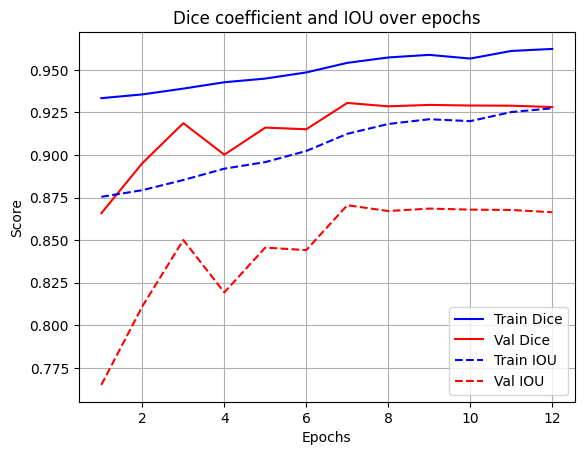

In [27]:
def plot_metrics(history):
    epochs = range(1, len(history_dice2.history['dice_coef']) + 1)

    # Dice coefficient
    plt.plot(epochs, history_dice2.history['dice_coef'], 'b-', label='Train Dice')
    plt.plot(epochs, history_dice2.history['val_dice_coef'], 'r-', label='Val Dice')

    # IOU
    plt.plot(epochs, history_dice2.history['iou_metric'], 'b--', label='Train IOU')
    plt.plot(epochs, history_dice2.history['val_iou_metric'], 'r--', label='Val IOU')

    plt.title('Dice coefficient and IOU over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(history_dice2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


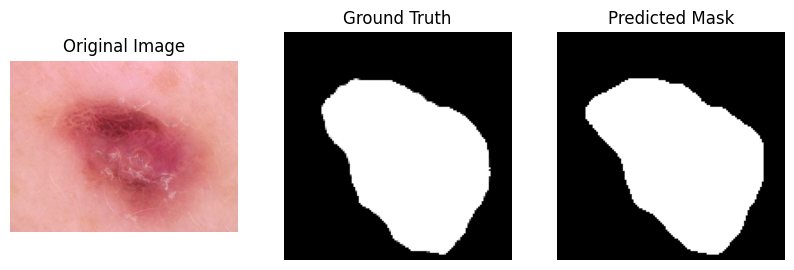

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


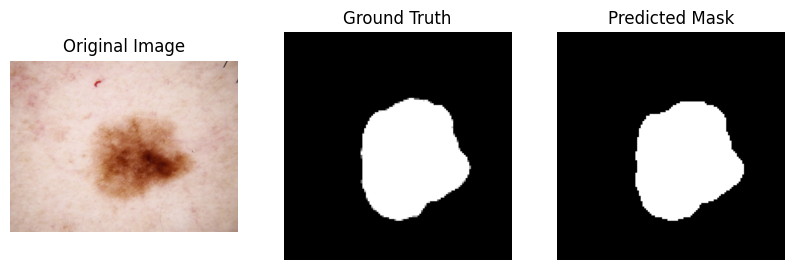

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


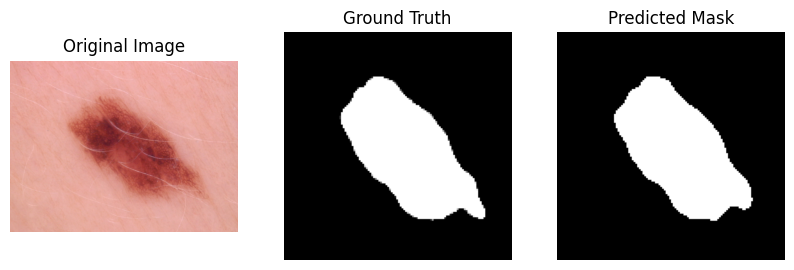

In [29]:
def show_predictions(model, sample_keys, images_dict, masks_dict, img_size=(128, 128), num_samples=3):
    keys_to_show = random.sample(sample_keys, num_samples)

    for key in keys_to_show:
        # Load image
        img = cv2.imread(images_dict[key])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, img_size) / 255.0

        # Load mask (ground truth)
        mask = cv2.imread(masks_dict[key], cv2.IMREAD_GRAYSCALE)
        mask_resized = cv2.resize(mask, img_size) / 255.0

        # Predict mask
        pred_mask = model.predict(np.expand_dims(img_resized, axis=0))[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8)

        # Plot
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_resized, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Example usage:
show_predictions(model2, val_keys, images_dict, masks_dict, img_size=(128, 128))



In [31]:
results = model2.evaluate(X_test, Y_test, batch_size=32)
print("Test Loss, Dice Coefficient, IoU:", results)


47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 476ms/step - dice_coef: 0.9299 - iou_metric: 0.8696 - loss: 0.0701
Test Loss, Dice Coefficient, IoU: [0.07195470482110977, 0.9280449748039246, 0.8663355112075806]


In [30]:
model2.save('unet_model_dice.h5')
